In [ ]:
import jax
jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp
from jaxopt import Bisection

@jax.jit
def wrap(l):
    def F(x):
        return x ** 3 - x - 2

    bisec = Bisection(optimality_fun=F, lower=1, upper=2, jit=True, check_bracket=False)
    return bisec.run().params

wrap(1)

In [ ]:
def F(x):
        return x ** 3 - x - 2

bisec = Bisection(optimality_fun=F, lower=1, upper=2, jit=True, check_bracket=False)
bisec.run().state.error

In [ ]:

import jax

jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp

from squishyplanet import OblateSystem

import astropy.units as u
import matplotlib.pyplot as plt
from tqdm import tqdm


def test_projected_parameterization():
    key = jax.random.PRNGKey(0)
    t_exp = 5 * u.min
    times = jnp.arange(-30, 30, t_exp.to(u.hour).value) * u.hour.to(u.day)

    for i in tqdm(range(1_000)):
        key, *subkeys = jax.random.split(key, (5,))

        # the 3d planet
        injected_state = {
            "t_peri" : -1071.23205 / 4,
            "times" : times,
            "exposure_time" : t_exp.to(u.day).value,
            "oversample" : 1, # 5x more samples under-the-hood, then binned back down
            "oversample_correction_order" : 2,
            "a" : 540.0,
            "period" : 1071.23205,
            "r" : 0.1,
            "i" : 89.9720 * jnp.pi/180,
            "ld_u_coeffs":jnp.array([0.4, 0.26]),
            "f1" : jax.random.uniform(subkeys[0], (1,), minval=0.0, maxval=0.5),
            "f2" : jax.random.uniform(subkeys[1], (1,), minval=0.0, maxval=0.5),
            "obliq" : jax.random.uniform(subkeys[2], (1,), minval=0.0, maxval=jnp.pi),
            "prec" : jax.random.uniform(subkeys[3], (1,), minval=0.0, maxval=jnp.pi),
            "tidally_locked" : False
        }

        planet1 = OblateSystem(**injected_state)
        lc1 = planet1.lightcurve()

        # the 2d planet
        injected_state2 = {
            "t_peri" : -1071.23205 / 4,
            "times" : times,
            "exposure_time" : t_exp.to(u.day).value,
            "oversample" : 1, # 5x more samples under-the-hood, then binned back down
            "oversample_correction_order" : 2,
            "a" : 540.0,
            "period" : 1071.23205,
            "i" : 89.9720 * jnp.pi/180,
            "ld_u_coeffs":jnp.array([0.4, 0.26]),
            "tidally_locked" : False,
            "parameterize_with_projected_ellipse" : True,
            "projected_effective_r" : planet1.state["projected_effective_r"][0],
            "projected_f" : planet1.state["projected_f"],
            "projected_theta" : planet1.state["projected_theta"],
        }

        planet2 = OblateSystem(**injected_state2)
        lc2 = planet2.lightcurve()

        if jnp.max(jnp.abs(lc1 - lc2)) > 1e-9:
            print(f"blegh, {i}")
            return injected_state, injected_state2, lc1, lc2
        assert jnp.allclose(lc1, lc2)


s1, s2, lc1, lc2 = test_projected_parameterization()
# test_projected_parameterization()

plt.plot(lc1)
plt.plot(lc2)

planet1 = OblateSystem(**s1)
planet2 = OblateSystem(**s2)

bad = jnp.where(lc2 < 0.99)[0][0]

In [ ]:
from squishyplanet.engine.polynomial_limb_darkened_transit import parameterize_2d_helper
from squishyplanet.engine.kepler import skypos

planet1 = OblateSystem(**s1)
planet2 = OblateSystem(**s2)

bad = jnp.where(lc2 < 0.99)[0][0]
d = {
    "rho_xx" : planet2._coeffs_2d["rho_xx"][0],
    "rho_xy" : planet2._coeffs_2d["rho_xy"][0],
    "rho_yy" : planet2._coeffs_2d["rho_yy"][0],
    "rho_x0" : planet2._coeffs_2d["rho_x0"][bad],
    "rho_y0" : planet2._coeffs_2d["rho_y0"][bad],
    "rho_00" : planet2._coeffs_2d["rho_00"][bad],
}


state = planet2._state
positions = skypos(**state)
area = jnp.pi * state["projected_effective_r"]**2
r1 = jnp.sqrt(area / ((1-state["projected_f"]) * jnp.pi))
r2 = r1 * (1 - state["projected_f"])
two, para = parameterize_2d_helper(
    r1,
    state["projected_f"],
    state["projected_theta"],
    positions[0, :],
    positions[1, :],
)

d2 = {
    "rho_xx" : two["rho_xx"][0],
    "rho_xy" : two["rho_xy"][0],
    "rho_yy" : two["rho_yy"][0],
    "rho_x0" : two["rho_x0"][bad],
    "rho_y0" : two["rho_y0"][bad],
    "rho_00" : two["rho_00"][bad],
}

d, d2

In [ ]:
planet1 = OblateSystem(**s1)
planet2 = OblateSystem(**s2)

lc1 = planet1.lightcurve()
lc2 = planet2.lightcurve()

bad = jnp.where(lc2 < 0.99)[0][0]
bad -= 0
print(bad)
print(lc1[bad] - lc2[bad])
print()

d1 = {
    "rho_xx" : planet1._coeffs_2d["rho_xx"][0],
    "rho_xy" : planet1._coeffs_2d["rho_xy"][0],
    "rho_yy" : planet1._coeffs_2d["rho_yy"][0],
    "rho_x0" : planet1._coeffs_2d["rho_x0"][bad],
    "rho_y0" : planet1._coeffs_2d["rho_y0"][bad],
    "rho_00" : planet1._coeffs_2d["rho_00"][bad],
}

d2 = {
    "rho_xx" : planet2._coeffs_2d["rho_xx"][0],
    "rho_xy" : planet2._coeffs_2d["rho_xy"][0],
    "rho_yy" : planet2._coeffs_2d["rho_yy"][0],
    "rho_x0" : planet2._coeffs_2d["rho_x0"][bad],
    "rho_y0" : planet2._coeffs_2d["rho_y0"][bad],
    "rho_00" : planet2._coeffs_2d["rho_00"][bad],
}

for key in d1:
    print(key, d1[key]-d2[key])

In [ ]:
planet2.illustrate(times=planet2.state["times"][bad])

In [ ]:
from squishyplanet.engine.parametric_ellipse import poly_to_parametric
p1 = poly_to_parametric(**d1)
p2 = poly_to_parametric(**d2)

for key in p1.keys():
    if p1[key].shape == (1,):
        p1[key] = p1[key][0]
        p2[key] = p2[key][0]
p1, p2

In [ ]:
from squishyplanet.engine.polynomial_limb_darkened_transit import (
    cartesian_intersection_to_parametric_angle,
    _single_intersection_points,
)

p = p2
d = d2

intersections = _single_intersection_points(**d)
alphas = jnp.linspace(0, 2*jnp.pi, 1000)
xs = p["c_x1"]*jnp.cos(alphas) + p["c_x2"]*jnp.sin(alphas) + p["c_x3"]
ys = p["c_y1"]*jnp.cos(alphas) + p["c_y2"]*jnp.sin(alphas) + p["c_y3"]
s_x = jnp.cos(alphas)
s_y = jnp.sin(alphas)
fig, ax = plt.subplots()
ax.plot(xs,ys)
ax.plot(s_x, s_y, ls="--", color="k")
ax.set(xlim=(-1.2, -0.7), ylim=(-0.40,-0.15), aspect='equal')

plt.scatter(intersections[0], intersections[1], color="r")

In [ ]:
p = p2

alphas = jnp.linspace(0, 2*jnp.pi, 1000)
xs = p["c_x1"]*jnp.cos(alphas) + p["c_x2"]*jnp.sin(alphas) + p["c_x3"]
ys = p["c_y1"]*jnp.cos(alphas) + p["c_y2"]*jnp.sin(alphas) + p["c_y3"]
s_x = jnp.cos(alphas)
s_y = jnp.sin(alphas)
fig, ax = plt.subplots()
ax.plot(xs,ys)
ax.plot(s_x, s_y, ls="--", color="k")
ax.set(xlim=(-1.2, -0.7), ylim=(-0.40,-0.15), aspect='equal')

alphas = cartesian_intersection_to_parametric_angle(
    intersections[0],
    intersections[1],
    **p1,
)

xs = p["c_x1"]*jnp.cos(alphas) + p["c_x2"]*jnp.sin(alphas) + p["c_x3"]
ys = p["c_y1"]*jnp.cos(alphas) + p["c_y2"]*jnp.sin(alphas) + p["c_y3"]
plt.scatter(xs, ys, color="r")

In [ ]:
d = d2
para = p2


xs, ys = intersections = _single_intersection_points(**d)

alphas = cartesian_intersection_to_parametric_angle(xs, ys, **para)
alphas = jnp.where(xs != 999, alphas, 2 * jnp.pi)
alphas = jnp.where(alphas < 0, alphas + 2 * jnp.pi, alphas)
alphas = jnp.where(alphas > 2 * jnp.pi, alphas - 2 * jnp.pi, alphas)
alphas = jnp.sort(alphas)

test_ang = alphas[0] + (alphas[1] - alphas[0]) / 2
test_ang = jnp.where(test_ang > 2 * jnp.pi, test_ang - 2 * jnp.pi, test_ang)

_x = (
    para["c_x1"] * jnp.cos(test_ang)
    + para["c_x2"] * jnp.sin(test_ang)
    + para["c_x3"]
)
_y = (
    para["c_y1"] * jnp.cos(test_ang)
    + para["c_y2"] * jnp.sin(test_ang)
    + para["c_y3"]
)
test_val = jnp.sqrt(_x**2 + _y**2)
test_val

In [ ]:
planet1.state["times"]

In [1]:

import jax

jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp

from squishyplanet import OblateSystem

import astropy.units as u
import matplotlib.pyplot as plt
from tqdm import tqdm


def test_projected_parameterization():
    key = jax.random.PRNGKey(0)
    t_exp = 5 * u.min
    times = jnp.arange(-30, 30, t_exp.to(u.hour).value) * u.hour.to(u.day)

    for i in tqdm(range(1_000)):
        key, *subkeys = jax.random.split(key, (5,))
        # if i < 529: continue

        # the 3d planet
        injected_state = {
            "t_peri" : -1071.23205 / 4,
            "times" : times,
            "exposure_time" : t_exp.to(u.day).value,
            "oversample" : 5, # 5x more samples under-the-hood, then binned back down
            "oversample_correction_order" : 2,
            "a" : 540.0,
            "period" : 1071.23205,
            "r" : 0.1,
            "i" : 89.9720 * jnp.pi/180,
            "ld_u_coeffs":jnp.array([0.4, 0.26]),
            "f1" : jax.random.uniform(subkeys[0], (1,), minval=0.0, maxval=0.5),
            "f2" : jax.random.uniform(subkeys[1], (1,), minval=0.0, maxval=0.5),
            "obliq" : jax.random.uniform(subkeys[2], (1,), minval=0.0, maxval=jnp.pi),
            "prec" : jax.random.uniform(subkeys[3], (1,), minval=0.0, maxval=jnp.pi),
            "tidally_locked" : False
        }

        planet1 = OblateSystem(**injected_state)
        lc1 = planet1.lightcurve()

        # the 2d planet
        injected_state2 = {
            "t_peri" : -1071.23205 / 4,
            "times" : times,
            "exposure_time" : t_exp.to(u.day).value,
            "oversample" : 5, # 5x more samples under-the-hood, then binned back down
            "oversample_correction_order" : 2,
            "a" : 540.0,
            "period" : 1071.23205,
            "i" : 89.9720 * jnp.pi/180,
            "ld_u_coeffs":jnp.array([0.4, 0.26]),
            "tidally_locked" : False,
            "parameterize_with_projected_ellipse" : True,
            "projected_effective_r" : planet1.state["projected_effective_r"][0],
            "projected_f" : planet1.state["projected_f"],
            "projected_theta" : planet1.state["projected_theta"],
        }

        planet2 = OblateSystem(**injected_state2)
        lc2 = planet2.lightcurve()

        if jnp.max(jnp.abs(lc1 - lc2)) > 1e-9:
            print(f"blegh, {i}")
            return injected_state, injected_state2, lc1, lc2
        assert jnp.allclose(lc1, lc2)


s1, s2, lc1, lc2 = test_projected_parameterization()


planet1 = OblateSystem(**s1)
planet2 = OblateSystem(**s2)

bad = jnp.where(jnp.abs(lc1-lc2) > 1e-9)[0][0]


100%|██████████| 1000/1000 [01:26<00:00, 11.53it/s]


TypeError: cannot unpack non-iterable NoneType object

In [36]:
s = s1.copy()
s["times"] = jnp.array([planet1.state["times"][bad]])
planet3 = OblateSystem(**s)

lca = planet3.lightcurve()

lca - lc1[bad]

xs: [-9.84526869e-01 -9.56780166e-01  9.99000000e+02  9.99000000e+02]
ys: [-1.75233685e-01 -2.90812162e-01  9.99000000e+02  9.99000000e+02]


alphas: [1.28477405 2.648591   6.28318531 6.28318531]
test_ang: 1.9666825237116825
test_val: 0.9861983089833014
init x: -0.9845268690118075
init x: -0.9567801660982073
init x: 999.0
init x: 999.0
init y: -0.17523368452956528
init y: -0.29081216233350166
init y: 999.0
init y: 999.0
c_x1: 0.002613770092677725
c_x2: 0.05082630925078992
c_x3: -1.0062790367256926
c_y1: -0.09993056740661747
c_y2: 0.0013294059114099114
c_y3: -0.26389331420444756
init loss: 0.03538780940359382
init loss: 0.006851457787924691
init loss: 1998721.115762679
init loss: 1998721.115762679
final loss: 7.518830502887769e-31
final loss: 3.944304526105059e-31
final loss: 1998595.390687858
final loss: 1998595.390687858
-0.0286703184138202
xs: [-9.85059182e-01 -9.54894213e-01  9.99000000e+02  9.99000000e+02]
ys: [-1.72216168e-01 -2.96946194e-01  9.99000000e+02  9.99000000e+02]


alph

Array([0.], dtype=float64)

In [37]:
s = s2.copy()
s["times"] = jnp.array([planet2.state["times"][bad]])
planet4 = OblateSystem(**s)

lcb = planet4.lightcurve()

lcb - lc2[bad]

xs: [-9.84526870e-01 -9.56780167e-01  9.99000000e+02  9.99000000e+02]
ys: [-1.75233679e-01 -2.90812159e-01  9.99000000e+02  9.99000000e+02]


alphas: [4.42636675 5.79018366 6.28318531 6.28318531]
test_ang: 5.10827520164496
test_val: 0.9861983099439834
init x: -0.9845268699311059
init x: -0.9567801669777897
init x: 999.0
init x: 999.0
init y: -0.17523367936461084
init y: -0.2908121594396509
init y: 999.0
init y: 999.0
c_x1: -0.0026137702450418784
c_x2: -0.05082630770268875
c_x3: -1.0062790367256547
c_y1: 0.09993057323185732
c_y2: -0.001329405870917984
c_y3: -0.26389331420444634
init loss: 0.001042445006934176
init loss: 0.01926094897698457
init loss: 1998360.6771772404
init loss: 1998360.6771772404
final loss: 1.1840617298092726e-30
final loss: 6.810088283353266e-31
final loss: 1998324.0963863085
final loss: 1998324.0963863085
-0.028670319059862472
xs: [-9.85059183e-01 -9.54894213e-01  9.99000000e+02  9.99000000e+02]
ys: [-1.72216162e-01 -2.96946193e-01  9.99000000e+02  9.99000000e+02]


Array([0.], dtype=float64)

In [38]:
from squishyplanet.engine.parametric_ellipse import poly_to_parametric
from squishyplanet.engine.polynomial_limb_darkened_transit import _single_intersection_points

d1 = {
    "rho_xx" : planet1._coeffs_2d["rho_xx"][0],
    "rho_xy" : planet1._coeffs_2d["rho_xy"][0],
    "rho_yy" : planet1._coeffs_2d["rho_yy"][0],
    "rho_x0" : planet1._coeffs_2d["rho_x0"][bad],
    "rho_y0" : planet1._coeffs_2d["rho_y0"][bad],
    "rho_00" : planet1._coeffs_2d["rho_00"][bad],
}

d2 = {
    "rho_xx" : planet2._coeffs_2d["rho_xx"][0],
    "rho_xy" : planet2._coeffs_2d["rho_xy"][0],
    "rho_yy" : planet2._coeffs_2d["rho_yy"][0],
    "rho_x0" : planet2._coeffs_2d["rho_x0"][bad],
    "rho_y0" : planet2._coeffs_2d["rho_y0"][bad],
    "rho_00" : planet2._coeffs_2d["rho_00"][bad],
}

d3 = {
    "rho_xx" : planet3._coeffs_2d["rho_xx"][0],
    "rho_xy" : planet3._coeffs_2d["rho_xy"][0],
    "rho_yy" : planet3._coeffs_2d["rho_yy"][0],
    "rho_x0" : planet3._coeffs_2d["rho_x0"][0],
    "rho_y0" : planet3._coeffs_2d["rho_y0"][0],
    "rho_00" : planet3._coeffs_2d["rho_00"][0],
}

d4 = {
    "rho_xx" : planet4._coeffs_2d["rho_xx"][0],
    "rho_xy" : planet4._coeffs_2d["rho_xy"][0],
    "rho_yy" : planet4._coeffs_2d["rho_yy"][0],
    "rho_x0" : planet4._coeffs_2d["rho_x0"][0],
    "rho_y0" : planet4._coeffs_2d["rho_y0"][0],
    "rho_00" : planet4._coeffs_2d["rho_00"][0],
}

p1 = poly_to_parametric(**d1)
p2 = poly_to_parametric(**d2)
p3 = poly_to_parametric(**d3)
p4 = poly_to_parametric(**d4)


for key in p1.keys():
    if p1[key].shape == (1,):
        p1[key] = p1[key][-1]
        p2[key] = p2[key][-1]
        p3[key] = p3[key][-1]
        p4[key] = p4[key][-1]

In [39]:
@jax.jit
def cartesian_intersection_to_parametric_angle(
    xs,
    ys,
    c_x1,
    c_x2,
    c_x3,
    c_y1,
    c_y2,
    c_y3,
):
    """
    Given a set of x and y coordinates corresponding to the intersection of the planet
    and star, compute the angle :math:`\\alpha` that corresponds to each point.

    Here, :math:`\\alpha` is the parameter in the parametric equations of the ellipse.
    See :func:`poly_to_parametric` for more details.

    Args:
        xs (Array [Rstar]): x-coordinates of the intersection points
        ys (Array [Rstar]): y-coordinates of the intersection points
        c_x1 (Array [Dimensionless]): Coefficient of x^2
        c_x2 (Array [Dimensionless]): Coefficient of xy
        c_x3 (Array [Dimensionless]): Coefficient of x
        c_y1 (Array [Dimensionless]): Coefficient of y^2
        c_y2 (Array [Dimensionless]): Coefficient of y
        c_y3 (Array [Dimensionless]): Constant term

    Returns:
        Array [Rstar]: The angle :math:`\\alpha` corresponding to each intersection point

    """

    def inner(x, y):
        def loss(alpha):
            x_alpha = c_x1 * jnp.cos(alpha) + c_x2 * jnp.sin(alpha) + c_x3
            y_alpha = c_y1 * jnp.cos(alpha) + c_y2 * jnp.sin(alpha) + c_y3

            return (x - x_alpha) ** 2 + (y - y_alpha) ** 2

        # could have just used autograd, but it's simple enough to do by hand
        def grad_loss(alpha):
            return 2 * (c_x2 * jnp.cos(alpha) - c_x1 * jnp.sin(alpha)) * (
                c_x3 - x + c_x1 * jnp.cos(alpha) + c_x2 * jnp.sin(alpha)
            ) + 2 * (c_y2 * jnp.cos(alpha) - c_y1 * jnp.sin(alpha)) * (
                c_y3 - y + c_y1 * jnp.cos(alpha) + c_y2 * jnp.sin(alpha)
            )

        def scan_func(alpha, _):
            # rarely, but sometimes, it actually reaches loss=0 and grad=0
            # in that case, it throws nans when it tries to divide and everything
            # following that is wrong
            l = loss(alpha)
            g = grad_loss(alpha)

            def not_converged(alpha):
                return alpha - l / g, None

            def converged(alpha):
                return alpha, None

            return jax.lax.cond(jnp.abs(g) > 1e-16, not_converged, converged, alpha)

        # if it starts on the actual value, will get nans
        # previously had it start at 0, but in idealized cases used for testing it really is 0
        jax.debug.print("init x: {x}", x=x)
        jax.debug.print("init y: {y}", y=y)
        jax.debug.print("c_x1: {x}", x=c_x1)
        jax.debug.print("c_x2: {x}", x=c_x2)
        jax.debug.print("c_x3: {x}", x=c_x3)
        jax.debug.print("c_y1: {x}", x=c_y1)
        jax.debug.print("c_y2: {x}", x=c_y2)
        jax.debug.print("c_y3: {x}", x=c_y3)
        jax.debug.print("init loss: {x}", x=loss(0.123))
        a = jax.lax.scan(scan_func, 0.123, None, length=50)[0]
        jax.debug.print("final loss: {x}", x=loss(a))
        # a = jax.lax.cond(loss(a) < 1e-9, lambda _: a, lambda _: jax.lax.scan(scan_func, 4.123, None, length=50)[0], None)
        #jax.debug.print("loss, try 2: {x}", x=loss(a))
        return a

    alphas = jax.vmap(inner)(xs, ys)
    alphas = jnp.mod(alphas, 2 * jnp.pi)
    alphas = jnp.where(alphas < 0, alphas + 2 * jnp.pi, alphas)
    return alphas

In [40]:
d = d4
para = p4

xs, ys = _single_intersection_points(**d)


alphas = cartesian_intersection_to_parametric_angle(xs, ys, **para)
alphas = jnp.where(xs != 999, alphas, 2 * jnp.pi)
alphas = jnp.where(alphas < 0, alphas + 2 * jnp.pi, alphas)
alphas = jnp.where(alphas > 2 * jnp.pi, alphas - 2 * jnp.pi, alphas)
alphas = jnp.sort(alphas)
alphas

init x: -0.9845268699311059
init x: -0.9567801669777897
init x: 999.0
init x: 999.0
init y: -0.17523367936461084
init y: -0.2908121594396509
init y: 999.0
init y: 999.0
c_x1: 0.002613770245041834
c_x2: 0.05082630770268791
c_x3: -1.0062790367256549
c_y1: -0.09993057323185565
c_y2: 0.001329405870917962
c_y3: -0.26389331420444634
init loss: 0.03538781349128595
init loss: 0.006851458971080279
init loss: 1998721.1157743216
init loss: 1998721.1157743216
final loss: 3.150821389017518e-31
final loss: 3.944304526105059e-31
final loss: 1998327.716986907
final loss: 1998327.716986907


Array([1.28477409, 2.648591  , 6.28318531, 6.28318531], dtype=float64)

In [41]:
planet3._para_coeffs_2d

{'c_x1': Array([0.00261377, 0.00261377, 0.00261377, 0.00261377, 0.00261377],      dtype=float64),
 'c_x2': Array([0.05082631, 0.05082631, 0.05082631, 0.05082631, 0.05082631],      dtype=float64),
 'c_x3': Array([-1.00627904, -1.00352964, -1.00078025, -0.99803086, -0.99528146],      dtype=float64),
 'c_y1': Array([-0.09993057, -0.09993057, -0.09993056, -0.09993057, -0.09993057],      dtype=float64),
 'c_y2': Array([0.00132941, 0.00132941, 0.00132941, 0.00132941, 0.00132941],      dtype=float64),
 'c_y3': Array([-0.26389331, -0.26389332, -0.26389332, -0.26389332, -0.26389332],      dtype=float64)}

In [42]:
planet4._para_coeffs_2d

{'c_x1': Array([-0.00261377, -0.00261377, -0.00261377, -0.00261377, -0.00261377],      dtype=float64),
 'c_x2': Array([-0.05082631, -0.05082631, -0.05082631, -0.05082631, -0.05082631],      dtype=float64),
 'c_x3': Array([-1.00627904, -1.00352964, -1.00078025, -0.99803086, -0.99528146],      dtype=float64),
 'c_y1': Array([0.09993057, 0.09993057, 0.09993057, 0.09993057, 0.09993057],      dtype=float64),
 'c_y2': Array([-0.00132941, -0.00132941, -0.00132941, -0.00132941, -0.00132941],      dtype=float64),
 'c_y3': Array([-0.26389331, -0.26389332, -0.26389332, -0.26389332, -0.26389332],      dtype=float64)}

In [43]:
p4

{'c_x1': Array(0.00261377, dtype=float64),
 'c_x2': Array(0.05082631, dtype=float64),
 'c_x3': Array(-1.00627904, dtype=float64),
 'c_y1': Array(-0.09993057, dtype=float64),
 'c_y2': Array(0.00132941, dtype=float64),
 'c_y3': Array(-0.26389331, dtype=float64)}

In [23]:
planet4.state["projected_theta"]

Array([2.0853213], dtype=float64)

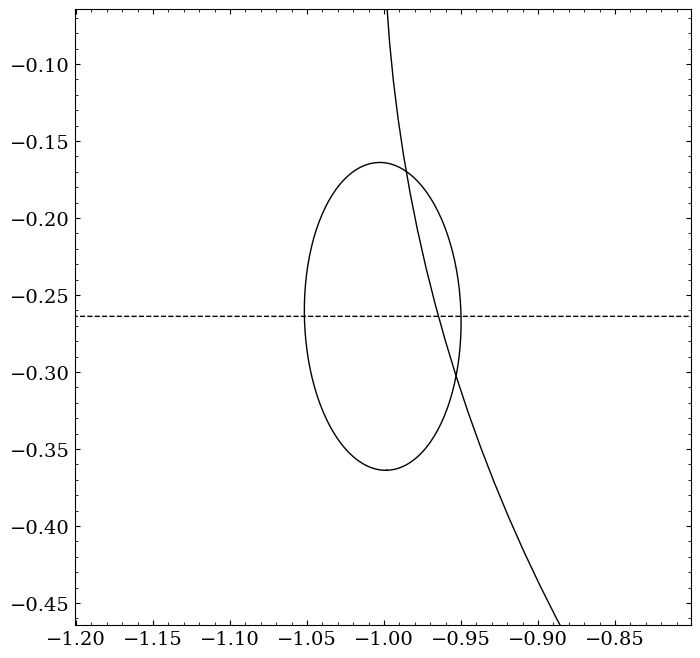

In [21]:
planet3.illustrate(star_fill=False, times=planet3.state["times"])

(2.6, 3.0)

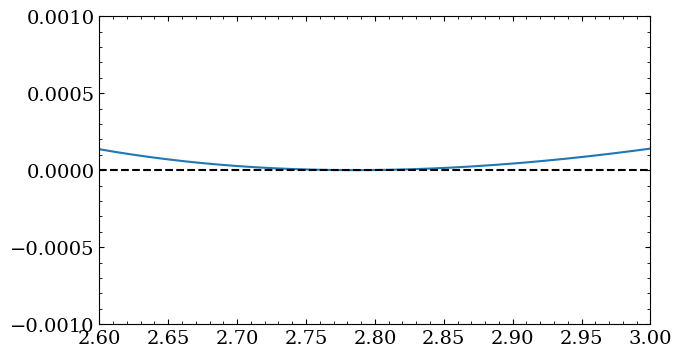

In [32]:
def demo(
    xs,
    ys,
    c_x1,
    c_x2,
    c_x3,
    c_y1,
    c_y2,
    c_y3
):
    x = xs[0]
    y = ys[0]
    def loss(alpha):
        x_alpha = c_x1 * jnp.cos(alpha) + c_x2 * jnp.sin(alpha) + c_x3
        y_alpha = c_y1 * jnp.cos(alpha) + c_y2 * jnp.sin(alpha) + c_y3

        return (x - x_alpha) ** 2 + (y - y_alpha) ** 2

    alphas = jnp.linspace(0, 2*jnp.pi, 10_000)
    return loss(alphas)

a = demo(xs, ys, **para)
plt.plot(jnp.linspace(0, 2*jnp.pi, 10_000), a)
plt.axhline(0, color="k", ls="--")
plt.ylim(-1e-3, 1e-3)
plt.xlim(2.6, 3.0)
# plt.xlim(2.78486255 - 0.1, 2.78486255 + 0.1)